In [1]:
import os
import pandas as pd

# ingore future warning
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
# surprass chain warning
pd.set_option('mode.chained_assignment', None)
#warnings.filterwarnings("ignore", message=r"Passing", category=SettingWithCopyWarning)

print("Set the printing size of the pandas df... ")
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Set the printing size of the pandas df... 


# Load in data

### Reload from here

In [5]:
# get the path
path = os.getcwd()
files = os.listdir(path + '/data/excel/')

# filter excel
files_xlsx = [f for f in files if f[-4:] == 'xlsx']

# read excel
xls = pd.ExcelFile('data/excel.xlsx')
# init ls 
ls_pds = [] 
# looping sheets
for n in range(69):
    df = pd.read_excel(xls, 'sheet%s'%n)
    ls_pds.append(df)

# Load in labels

Obtain the binary label:  [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


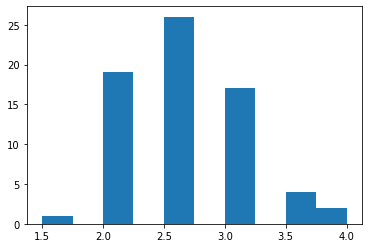

In [6]:
# load from excel 
labels_12 = pd.read_excel('data/NRS_LABEL.xlsx')

# get index for each example
idx = [i for i in range(len(files_xlsx))]
ls_idx = [12*i for i in idx]
#print("ls_idx: ", ls_idx)

# get every 12 labels (because each repeats 12 times)
labels = labels_12.iloc[ls_idx, :]

# sort by the first columns
labels_sort = labels.sort_values(labels.columns[0])
# add col 
labels_sort['name'] = files_xlsx
# print(labels_sort)

# label list 
labels_ls = labels_sort['nrs-score'].tolist()
import matplotlib.pyplot as plt
# plot histogram
plt.hist(labels_ls, density=False)

# get a binary list
binary_ls = [1 if i>=3 else 0 for i in labels_ls]
print("Obtain the binary label: ", binary_ls)

# Normalization: de-trend for each wave

### Four waves

In [9]:
""" 
func: 
    called by normalize a wave curve
args: 
    temp_ls: pd series
"""
def process_one_wave(temp_ls, plot=False):
    temp_ls = temp_ls.reset_index(drop=True)
    #plt.plot(temp_ls)

    # get long-term trend
    long_trend = temp_ls.rolling(50, center=True).mean()
    
    # get average of the long_trend 
    mid_trend = long_trend.mean()
    mid_trend_ls = [mid_trend for i in range(len(long_trend))]

    # get diff: (diff: long_trend - mid_trend_ls)
    diff = long_trend - mid_trend_ls
    
    # result
    ls_sub = temp_ls - diff
    # drop nan
    ls_sub = ls_sub.dropna()
    
    if plot: 
        plt.plot(temp_ls, label='original')
        plt.plot(long_trend, label='long_trend')
        plt.plot(mid_trend_ls, label='average')
        plt.plot(diff, label='diff')
        plt.plot(ls_sub, label='result')
        plt.legend()
        plt.show()
        
    # return the normalized
    return ls_sub.tolist()

""" 
func: 
    normalize a wave curve 
arg: 
    test: pd df 
    PLOT: bool
return: 
    series changed
"""
def output_four_wave(test, PLOT=False):
    
    # init an pandas
    df = pd.DataFrame() 
        
    """using func: """
    df['B1'] = process_one_wave(test['Z-B1'], plot=False)
    df['B2'] = process_one_wave(test['Z-B2'], plot=False)
    df['B3'] = process_one_wave(test['Z-B3'], plot=False)
    df['B4'] = process_one_wave(test['Z-B4'], plot=False)

    return df

In [10]:
# init pds_nor
four_wave = []
print("store normalized D in pds_nor")
# looping
for i in range(len(ls_pds)):
    #print("---------- ", binary_ls[i], " ------------")
    #print("---------- ", files_xlsx[i], " ------------")
    """using func: normalize_wave"""
    one_ex = output_four_wave(ls_pds[i], PLOT=False)
    four_wave.append(one_ex)

store normalized D in pds_nor


# Cross Ratio

In [25]:
import matplotlib.pyplot as plt
import numpy as np

In [39]:
print("ratio of abs(B1-B4)/abs(B2-B3) named as AD_BC")

print("input data: four_wave", len(four_wave))

print("target data: binary_ls", len(binary_ls))

""" 
func: 
    compute ratio of abs(B1-B4)/abs(B2-B3) named as AD_BC
arg: 
    one df named one_ex 
return: 
    plot AD_BC
"""
def AD_BC(one_ex): 
    
    # extract data from df
    B1 = one_ex['B1'].tolist()
    B2 = one_ex['B2'].tolist()
    B3 = one_ex['B3'].tolist()
    B4 = one_ex['B4'].tolist()
    
    # ratio 
    B14 = [abs(b1 - b4) for b1, b4 in zip(B1, B4)]
    B23 = [abs(b2 - b3) for b2, b3 in zip(B2, B3)]
    ratio = [b14/b23 for b14, b23 in zip(B14, B23)]
             
    # plot 
    return np.log(np.mean(ratio))

ratio of abs(B1-B4)/abs(B2-B3) named as AD_BC
input data: four_wave 69
target data: binary_ls 69


In [40]:
print("inspect each ratio for all cows")
# init a list to store the variable 
ls_value = [] 
# looping
for i in range(len(four_wave)): 
    """func: AD_BC"""
    ls_value.append(AD_BC(four_wave[i]))
    

inspect each ratio for all cows


we don't think cross ratio can represent the feature we aim to 


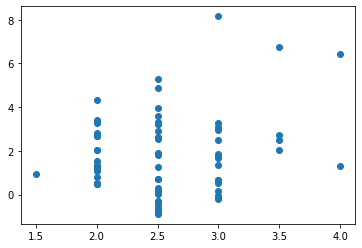

In [42]:
plt.scatter(labels_ls, ls_value)
print("we don't think cross ratio can represent the feature we aim to ")

# Area

In [53]:
""" 
func: 
    cummulative area of (AD) / cummulative area of (BC)
arg: 
    one df named one_ex 
return: 
    plot AREA
"""
def AREA(one_ex): 
    
    # extract data from df
    B1 = one_ex['B1'].tolist()
    B2 = one_ex['B2'].tolist()
    B3 = one_ex['B3'].tolist()
    B4 = one_ex['B4'].tolist()
    
    # ratio 
    B14 = [abs(b1 - b4) for b1, b4 in zip(B1, B4)]
    B23 = [abs(b2 - b3) for b2, b3 in zip(B2, B3)]
    area_diff = np.mean(B14) - np.mean(B23)
             
    # plot 
    plt.plot(B14, label="B14") 
    plt.plot(B23, label="B23")
    plt.legend() 
    plt.show()
    
    return area_diff

inspect each ratio for all cows
labels_ls:  3.0


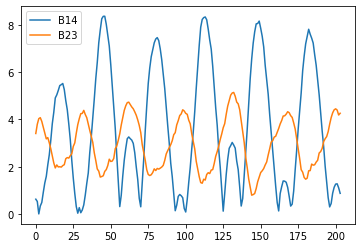

labels_ls:  2.5


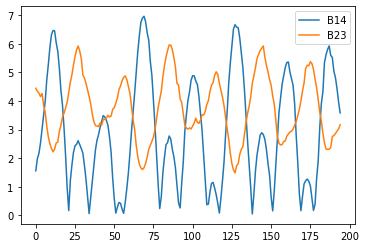

labels_ls:  3.0


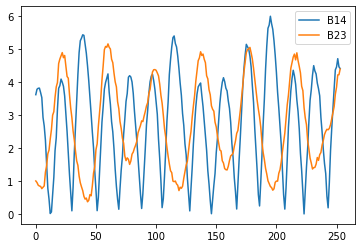

labels_ls:  2.0


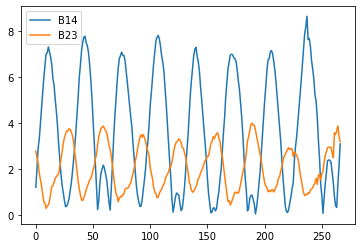

labels_ls:  2.0


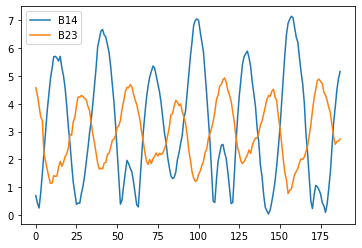

labels_ls:  2.5


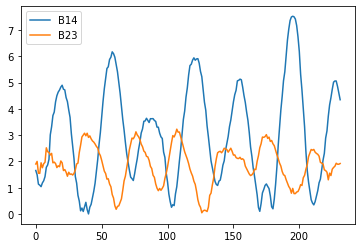

labels_ls:  2.5


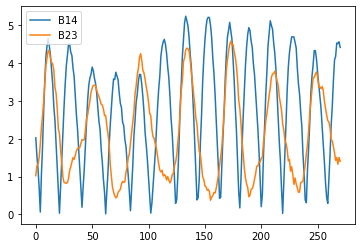

labels_ls:  2.5


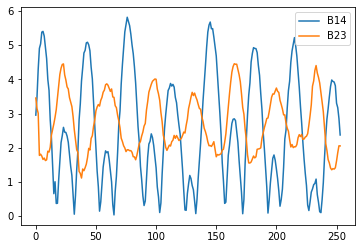

labels_ls:  3.0


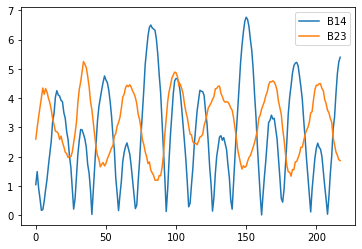

labels_ls:  2.5


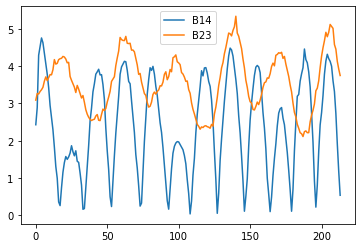

labels_ls:  2.5


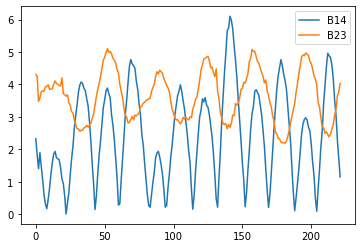

labels_ls:  2.5


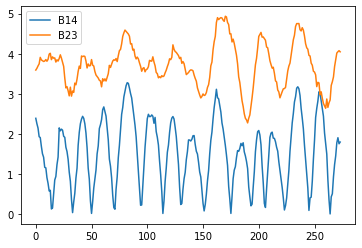

labels_ls:  3.0


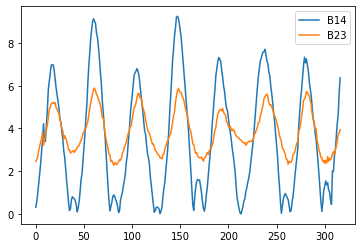

labels_ls:  2.5


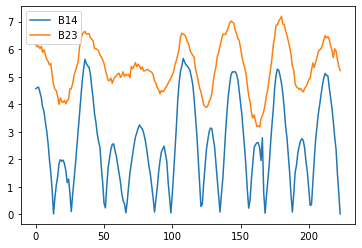

labels_ls:  2.5


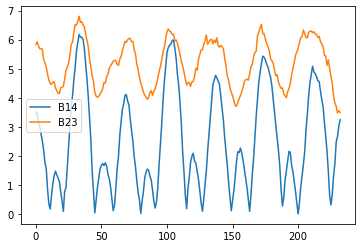

labels_ls:  2.5


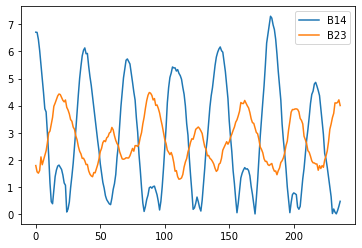

labels_ls:  3.0


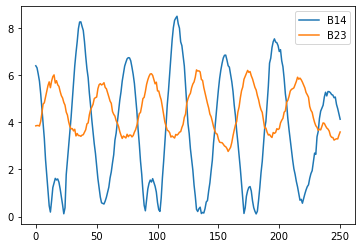

labels_ls:  3.0


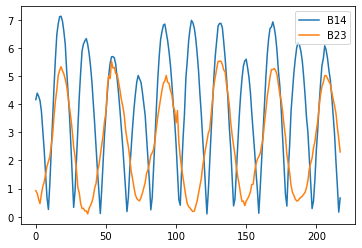

labels_ls:  3.0


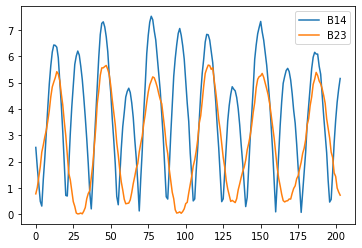

labels_ls:  3.0


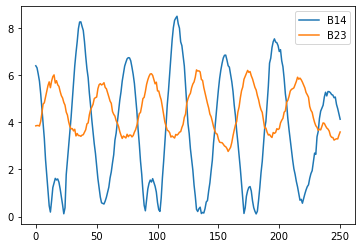

labels_ls:  2.0


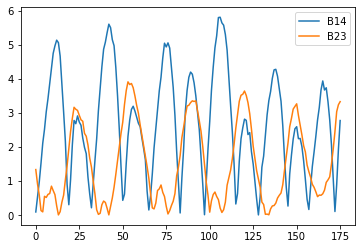

labels_ls:  2.0


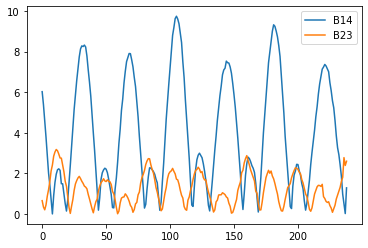

labels_ls:  2.5


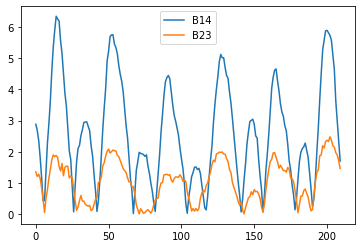

labels_ls:  2.0


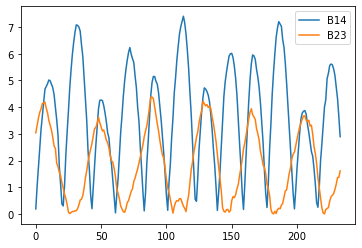

labels_ls:  2.0


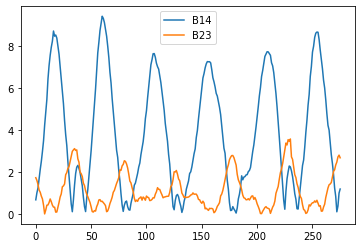

labels_ls:  2.5


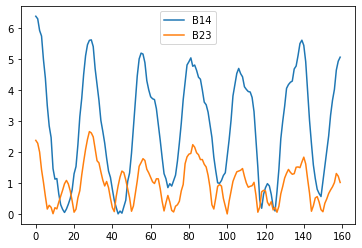

labels_ls:  3.0


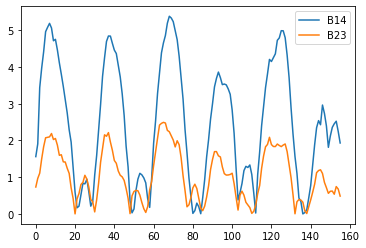

labels_ls:  2.0


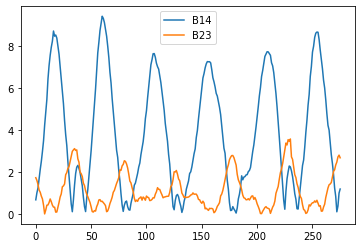

labels_ls:  4.0


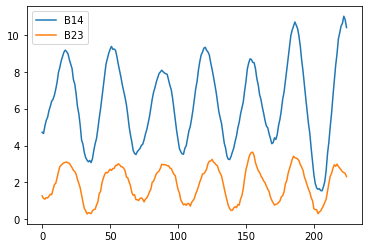

labels_ls:  2.0


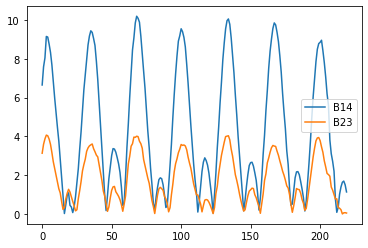

labels_ls:  2.0


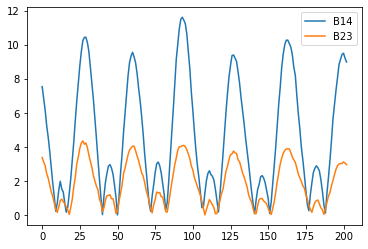

labels_ls:  2.0


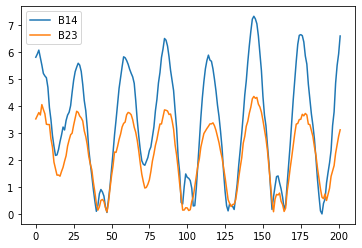

labels_ls:  2.0


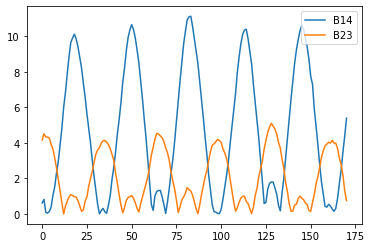

labels_ls:  3.5


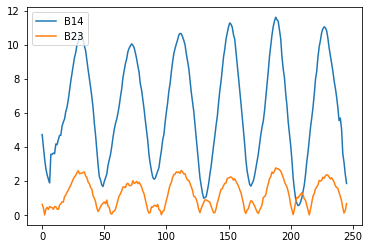

labels_ls:  3.0


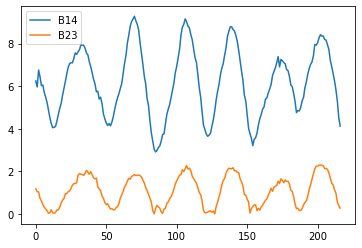

labels_ls:  2.5


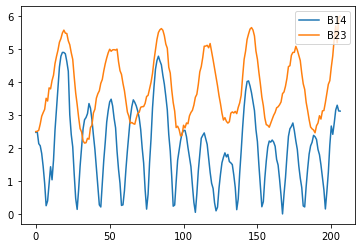

labels_ls:  2.5


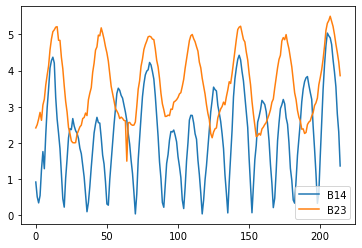

labels_ls:  2.5


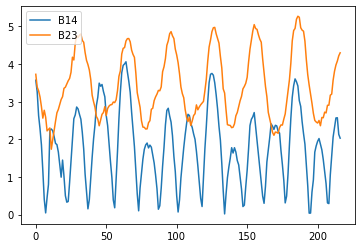

labels_ls:  2.0


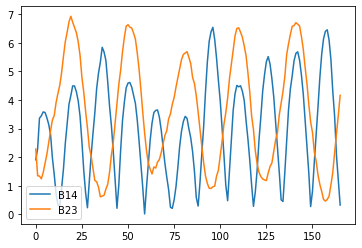

labels_ls:  3.5


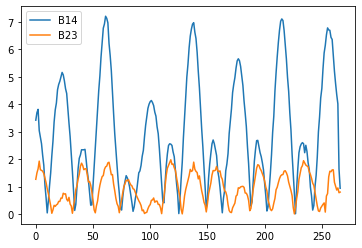

labels_ls:  3.0


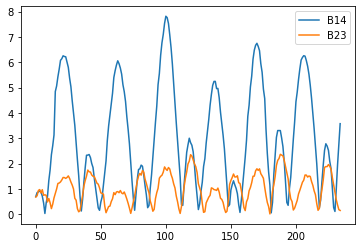

labels_ls:  3.0


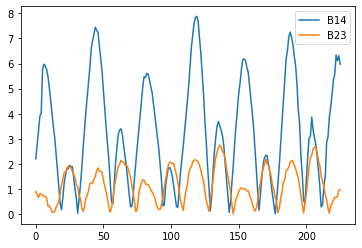

labels_ls:  3.5


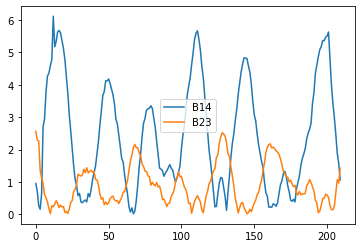

labels_ls:  2.0


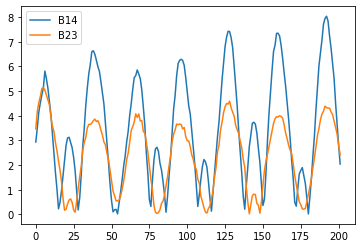

labels_ls:  2.0


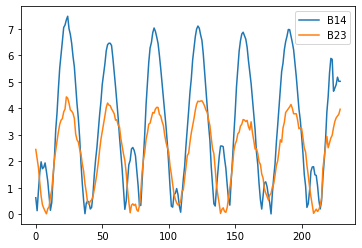

labels_ls:  2.5


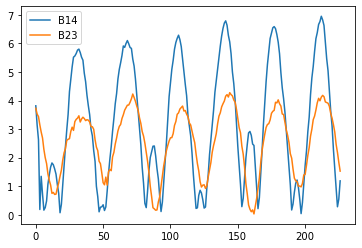

labels_ls:  3.0


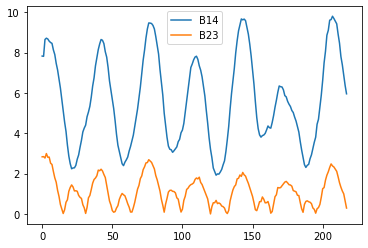

labels_ls:  3.0


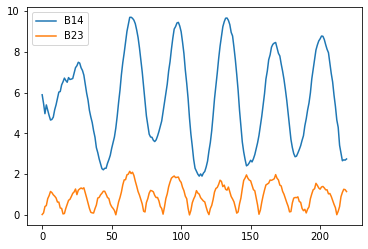

labels_ls:  2.0


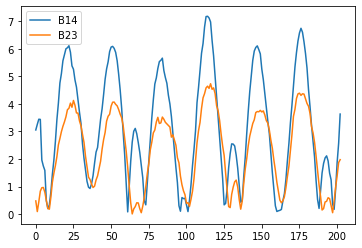

labels_ls:  2.0


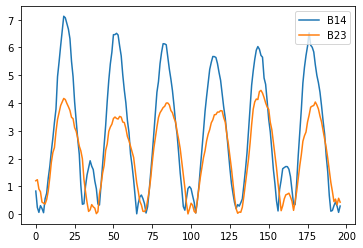

labels_ls:  2.5


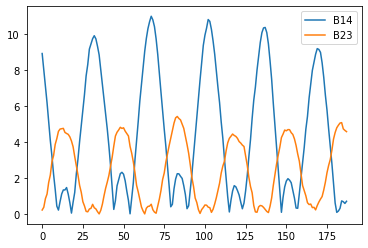

labels_ls:  2.5


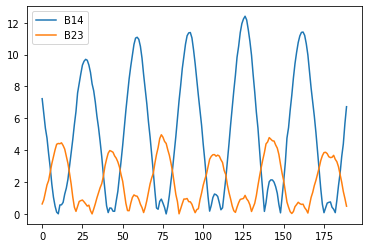

labels_ls:  3.0


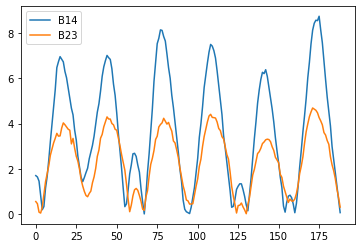

labels_ls:  3.0


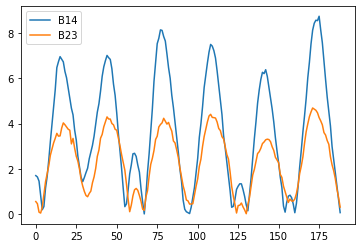

labels_ls:  1.5


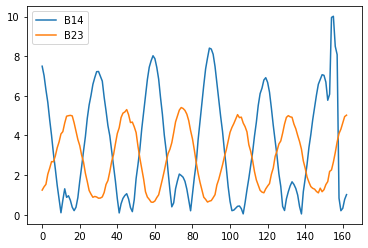

labels_ls:  2.0


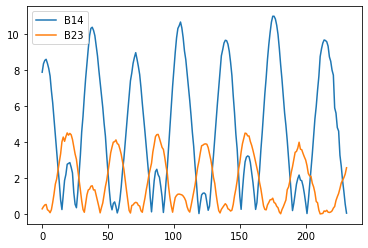

labels_ls:  2.5


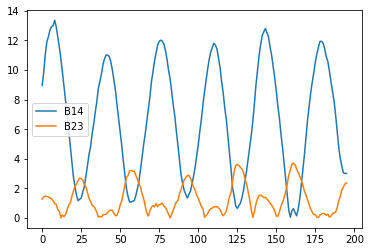

labels_ls:  4.0


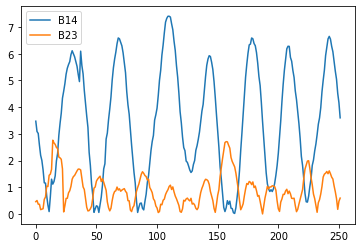

labels_ls:  3.5


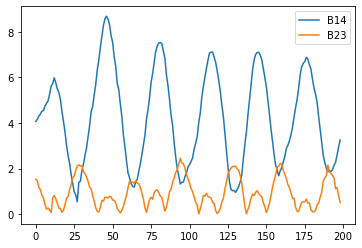

labels_ls:  2.0


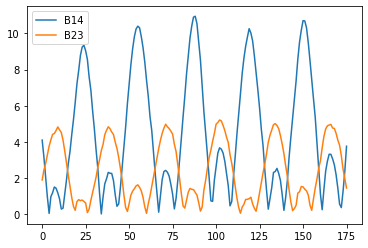

labels_ls:  2.0


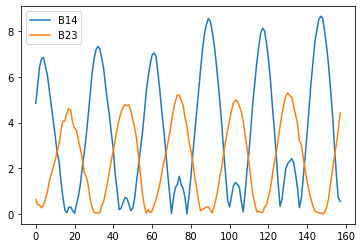

labels_ls:  2.5


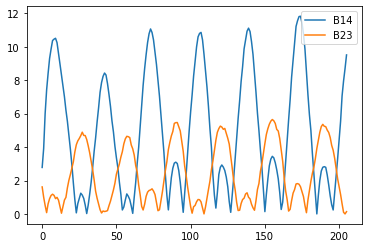

labels_ls:  2.5


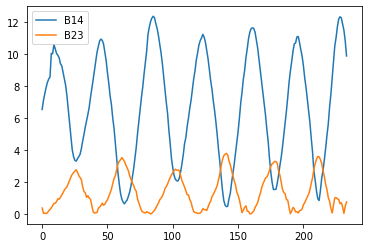

labels_ls:  2.5


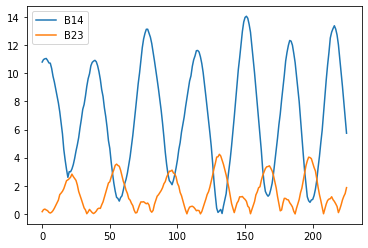

labels_ls:  2.5


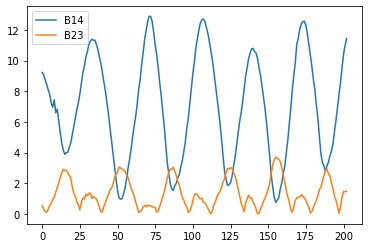

labels_ls:  2.5


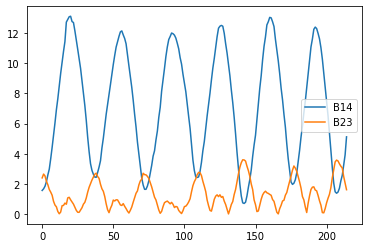

labels_ls:  2.5


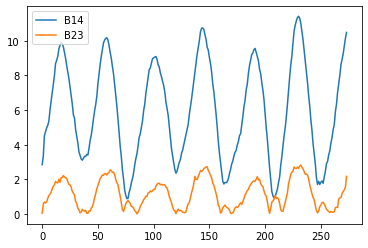

labels_ls:  2.5


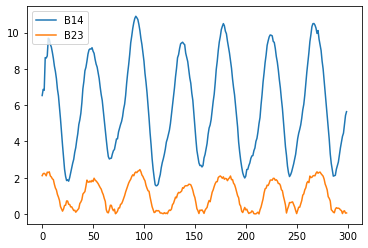

labels_ls:  3.0


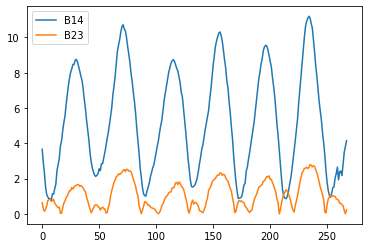

In [54]:
print("inspect each ratio for all cows")
# init a list to store the variable 
ls_area = [] 
# looping
for i in range(len(four_wave)): 
    """func: """
    print("labels_ls: ", labels_ls[i])
    area = AREA(four_wave[i])
    ls_area.append(area)
    

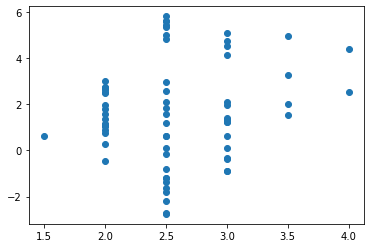

In [55]:
plt.scatter(labels_ls, ls_area)

# Extract wave-related variables

In [13]:
"""
func: 
    to analysis one wave 
    called by others
args: 
    wave: list[float]
    mean: float
return: 
    amp_f, lev_f, freq_f: float
"""
def analyze_wave(wave, mean):
    
    # check 
    #print("len(wave): ", len(wave))
    #print("wave: ", wave)

    # to ensure the each period starts at increasing point 
    # the sign has to from neg to pos
    # this point has condition: now is pos but has previous neg values 
    for i in range(1, len(wave)):
        
        #print("min(wave[:i]): ", min(wave[:i]))
        if (wave[i] < mean) and (wave[i+1] > mean) and (min(wave[:i])<mean):
            wave = wave[i:]
            break

    # find the intersection points by the change of sign
    # bool
    sign = (wave[0]>mean)
    # init list to store idx
    idx_ls = []
    # loop wave
    for i in range(len(wave)): 
        # dynamic sign 
        sign_dyn = (wave[i]>mean) 
        # compare sign 
        if sign != sign_dyn: 
            # append
            idx_ls.append(i)
            # reset sign 
            sign = ~sign

    #print(idx_ls, len(idx_ls))
    # init amp, level, freq
    amp, lev, freq = [], [], []

    # now for each three points, we have a period 
    # looping period by idx
    for idx in range(0, len(idx_ls)-2, 2): 
        # this is the index for periods
        id1, id2, id3 = idx_ls[idx], idx_ls[idx+1], idx_ls[idx+2]
        # amp
        amp.append( (max(wave[id1:id2])-mean) + (mean-min(wave[id2:id3])) )
        # level 
        lev.append( sum(wave[id1:id3])/len(wave[id1:id3]) )
        # freq 
        freq.append( 1/(id3-id1) )

    #print("amp, lev, freq: ", amp, lev, freq)
    amp_f, lev_f, freq_f = sum(amp)/len(amp), sum(lev)/len(lev), sum(freq)/len(freq)

    return amp_f, lev_f, freq_f
    

In [14]:
"""
func: 
    extract variables from each wave 
args: 
    pds_nor: list[df]
return: 
    D1_var, D2_var, Diff: list[float]
"""
def extract_four_wave(pds_nor):
    
    # init D1_variable, ...
    var_ls = []

    # looping pds_nor
    for df_idx in range(len(pds_nor)): 
        
        # obtain the list of wave and mean 
        wave = pds_nor[df_idx]['B1'].tolist()
        mean = pds_nor[df_idx]['B1'].mean()
        """using func: """
        amp_1, lev_1, freq_1 = analyze_wave(wave, mean)
        
        # obtain the list of wave and mean 
        wave = pds_nor[df_idx]['B2'].tolist()
        mean = pds_nor[df_idx]['B2'].mean()
        """using func: """
        amp_2, lev_2, freq_2 = analyze_wave(wave, mean)
        
        # obtain the list of wave and mean 
        wave = pds_nor[df_idx]['B3'].tolist()
        mean = pds_nor[df_idx]['B3'].mean()
        """using func: """
        amp_3, lev_3, freq_3 = analyze_wave(wave, mean)
        
        # obtain the list of wave and mean 
        wave = pds_nor[df_idx]['B4'].tolist()
        mean = pds_nor[df_idx]['B4'].mean()
        """using func: """
        amp_4, lev_4, freq_4 = analyze_wave(wave, mean)
        
        
        # compute diff 
        amp_f = amp_4 + amp_1 - amp_2 - amp_3
        lev_f = lev_4 + lev_1 - lev_2 - lev_3
        freq_f = freq_4 + freq_1 - freq_2 - freq_3
        
        # append 
        var_ls.append([amp_f, lev_f, freq_f]) 

    return var_ls

In [18]:
"""using func: """
var_ls = extract_four_wave(four_wave)


### Plot and examine these variables

In [19]:
# e.g. diff of amp, diff of level 
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure

""" 
args: 
    np_data: 2d array
    dim1, dim2: int (columns index in np_data for plotting)
    label_str: list[str]
"""
def plot_2d_scatter(np_data, dim1, dim2, label_str):
    scatter_x = np_data[:, dim1]
    scatter_y = np_data[:, dim2]
    group = np.array(binary_ls)
    cdict = {0: 'forestgreen', 1: 'indigo'}

    fig, ax = plt.subplots()
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)

    plt.xlabel(label_str[dim1])
    plt.ylabel(label_str[dim2])
    ax.legend()
    plt.show()
    

"""
func: 

args: 
    np_data: 2d np array
"""
def plot_3d(np_data):
    fig = figure()
    ax = fig.add_subplot(projection='3d')

    scatter_x = np_data[:, 2]
    scatter_y = np_data[:, 1]
    scatter_z = np_data[:, 0]
    group = np.array(binary_ls)
    cdict = {0: 'forestgreen', 1: 'indigo'}

    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g, s = 100)

    ax.legend()
    plt.show()

# Visualization

Obtain the binary label:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


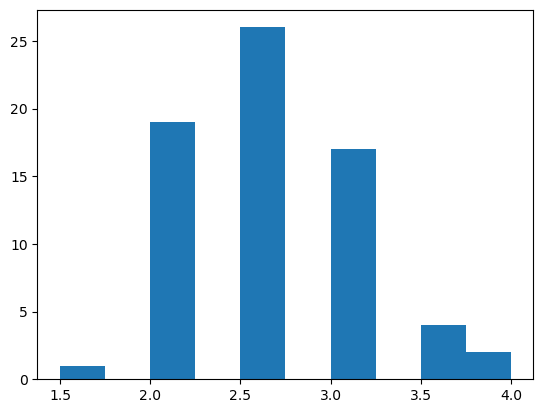

In [20]:

# plot histogram
plt.hist(labels_ls, density=False)
# get a binary list
binary_ls = [1 if i>=3.5 else 0 for i in labels_ls]
print("Obtain the binary label: ", binary_ls)

amp v.s. level


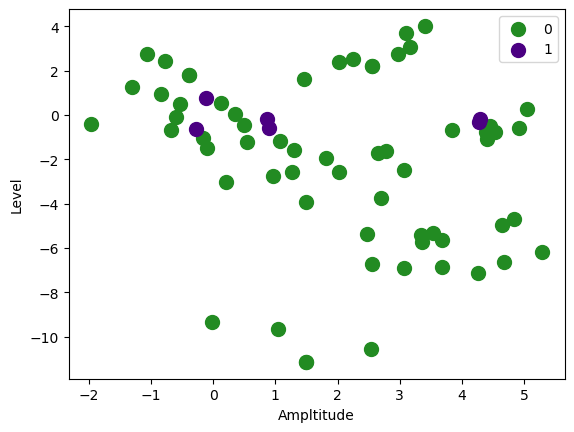

level v.s. freq


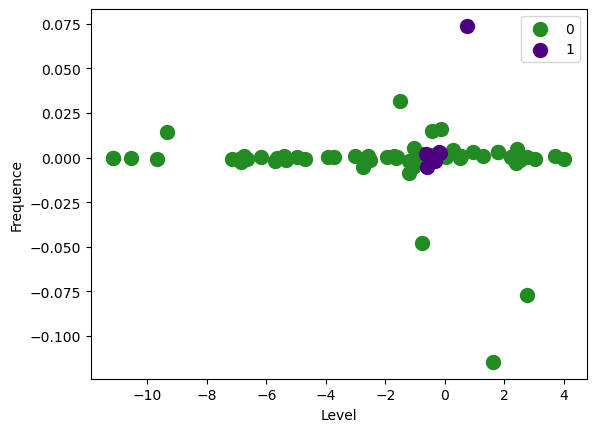

amp v.s. freq


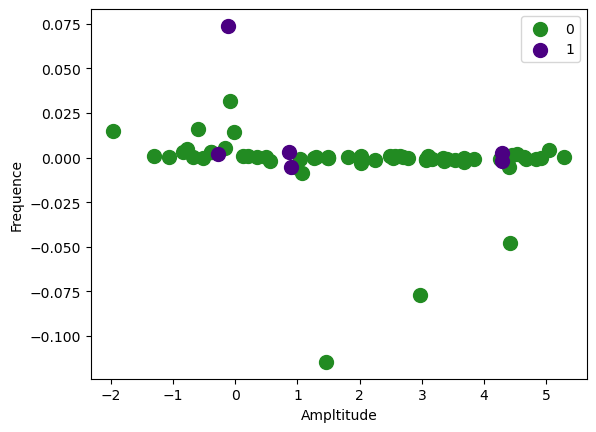

plot 3d


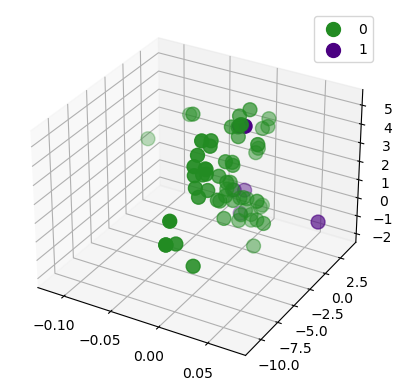

In [21]:
import numpy as np
# define input data for visualization 
np_data = np.array(var_ls)
# init labels 
label_str = ['Ampltitude', 'Level', 'Frequence']
"""using func: """
print("amp v.s. level")
plot_2d_scatter(np_data, 0, 1, label_str)
print("level v.s. freq")
plot_2d_scatter(np_data, 1, 2, label_str)
print("amp v.s. freq")
plot_2d_scatter(np_data, 0, 2, label_str)
print("plot 3d")
plot_3d(np_data)

### Find the center of the positive examples

In [26]:
# init x, y, z coordinates as list
y, z = [], []
# loop np_data 
for i in range(np_data.shape[0]): 
    # base on labels 
    if binary_ls[i] == 1:
        y.append(np_data[i, 1])
        z.append(np_data[i, 2])

y, z =  sum(y)/len(y), sum(z)/len(z)
print("y, z: ", y, z)

y, z:  -0.19740022926963738 0.01242827483622627


In [28]:
# init ls_euc for euclidean
ls_euc = [] 
# init for l1 list 
ls_l1 = []
# loop np_data 
for i in range(np_data.shape[0]): 
    # compute euclidean distance 
    euc_dis =  (np_data[i, 1] - y)**2 + (np_data[i, 2] - z)**2
    # compute the L1 distance 
    l1_dis =  abs(np_data[i, 1] - y) + abs(np_data[i, 2] - z)
    # append 
    ls_euc.append(euc_dis)
    # append 
    ls_l1.append(l1_dis)

In [33]:
for i in range(len(binary_ls)):
    if binary_ls[i] == 1: 
        print(ls_l1[i])

0.01931518743892198
0.14628877615635935
0.04378647745506993
0.42281647989057325
0.9994191907848047
0.4552374533945546


In [34]:
# init se, sp, auc list 
se_ls, sp_ls, auc_ls = [], [], []
threshold_ls = [0.8, 0.89, 0.9, 0.95, 1.0, 1.5]
for threshold in threshold_ls:
    # set prediction based on the threshold
    y_pred = [1 if abs(i) < threshold else 0 for i in ls_l1] 
    # set y test as our target
    y_test = binary_ls
    auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sp = tn / (tn + fp)
    se = tp / (tp + fn)
    # appending 
    se_ls.append(se) 
    sp_ls.append(sp) 
    auc_ls.append(auc)

    print("sp, se, auc: ", sp, se, auc)

sp, se, auc:  0.7777777777777778 0.8333333333333334 0.8055555555555556
sp, se, auc:  0.746031746031746 0.8333333333333334 0.7896825396825398
sp, se, auc:  0.746031746031746 0.8333333333333334 0.7896825396825398
sp, se, auc:  0.746031746031746 0.8333333333333334 0.7896825396825398
sp, se, auc:  0.746031746031746 1.0 0.873015873015873
sp, se, auc:  0.6349206349206349 1.0 0.8174603174603174


### Estimation based on observation

In [224]:
print("rough estimate SP, SE: ")
pos_pred = [1 if abs(i) < 0.85 else 0 for i in dd_pos]
neg_pred = [1 if abs(i) < 0.85 else 0 for i in dd_neg]
pred = pos_pred + neg_pred
print(pred)

rough estimate SP, SE: 
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [225]:
label = [1 for i in range(len(pos_pred))] + [0 for i in range(len(neg_pred))]

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

    
# this func requie y_test to have at least two classes
y_test, y_pred = label, pred
auc = roc_auc_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sp = tn / (tn + fp)
se = tp / (tp + fn)

print("sp, se, auc: ", sp, se, auc)

sp, se, auc:  0.847457627118644 1.0 0.923728813559322
